In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import os
import sys
current_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(current_dir, '..')))
from tokenizerManager import TokenizerManager
from data.utils_bbc import get_dataloaders as get_dataloaders_bbc

In [2]:
LOADDATASIZE = 510  # row of data
BATCH_SIZE = 8  # batch size
PAD_TOKEN_ID = 0

### check GPU avaiabel

In [3]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# load the dataset
df = pd.read_parquet('../data/NewsSummary.parquet')
# select the first 500 rows of the dataset
df = df.iloc[:500, :]
# select two columns
df = df[['ctext', 'text']]   # original text and summary
data = df.copy()
data.head()

,ctext,text
0,India will host its first WTA tournament in fi...,India will host its first WTA tournament in fi...
1,"Samajwadi Party vice-president Kiranmay Nanda,...","Ousted SP Vice President Kiranmoy Nanda, who w..."
2,"Gurgaon, Jul 7 (PTI) Gurgaon Police today regi...",Servers of a Gurugram-based clothing company h...
3,Cash-strapped holidaymakers are making their t...,Passengers are making their toddlers drag suit...
4,"London, Jun 30 (PTI) Supermodel Gigi Hadid say...",Model Gigi Hadid has said she cannot pull off ...


In [5]:
# from tokenizerManager import TokenizerManager

# df = pd.read_csv("../data/bbc-news-summary.csv").dropna()
# df["clean_article"] = df["Articles"].apply(TokenizerManager.clean_text)
# # print(df["clean_article"].head(10))
# print(df["clean_article"].iloc[0])
# print(df["Articles"].iloc[0])

In [6]:
TOKENIZER_MANAGER = TokenizerManager()
TOKENIZER_MANAGER.train_tokenizer_from_csv("../data/bbc-news-summary.csv")
TOKENIZER_MANAGER.save_tokenizer("../data/tokenizer.pkl")

TOKENIZER = TOKENIZER_MANAGER.load_tokenizer(load_path="../data/tokenizer.pkl")
print("tokenizer done, with length", len(TOKENIZER.word_index) + 1)


✅ Tokenizer 已构建，词表大小: 34994
✅ Tokenizer 已保存到: ../data/tokenizer.pkl
✅ Tokenizer 已加载: ../data/tokenizer.pkl
tokenizer done, with length 34994


In [7]:

train_loader, val_loader = get_dataloaders_bbc("../data/bbc-news-summary.csv", TOKENIZER, LOADDATASIZE, BATCH_SIZE)

Index(['File_path', 'Articles', 'Summaries'], dtype='object')


In [8]:
import torch
from model.LSTM_seq2seq import Encoder, Decoder, Seq2Seq, Attention

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
INPUT_DIM = len(TOKENIZER.word_index) + 1
OUTPUT_DIM = len(TOKENIZER.word_index) + 1
EMB_DIM = 256  # embedding dimension for both encoder and decoder
HID_DIM = 512  # hidden dimension for LSTM
N_LAYERS = 2

# 1. Attention
attn = Attention(enc_hid_dim=HID_DIM, dec_hid_dim=HID_DIM)

# 2. Encoder 和 Decoder（Decoder 加入 attn）
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, N_LAYERS) # 怎么设置
dec = Decoder(OUTPUT_DIM, EMB_DIM, enc_hid_dim=HID_DIM, dec_hid_dim=HID_DIM,
            attention=attn, num_layers=N_LAYERS)  # 怎么设置

# 3. Seq2Seq
model = Seq2Seq(enc, dec, DEVICE).to(DEVICE)

In [9]:
import torch.nn as nn
from tqdm import tqdm

train_loss_history = []
val_loss_history = []
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss(ignore_index=0)  # 0 是 padding id
  # use cross entropy loss for seq2seq model

for epoch in range(300):
    # ✅ Training
    model.train()
    total_train_loss = 0
    for src, trg in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        src, trg = src.to(DEVICE), trg.to(DEVICE)
        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        trg = trg[:, 1:].reshape(-1)
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    avg_train_loss = total_train_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)

    # ✅ Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for src, trg in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            src, trg = src.to(DEVICE), trg.to(DEVICE)
            output = model(src, trg)
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg)
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

Epoch 1 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch 1 - Train Loss: 7.4207 | Val Loss: 6.8982


Epoch 2 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Epoch 2 - Train Loss: 6.6449 | Val Loss: 6.8074


Epoch 3 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Epoch 3 - Train Loss: 6.5059 | Val Loss: 6.7497


Epoch 4 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


Epoch 4 - Train Loss: 6.4018 | Val Loss: 6.7227


Epoch 5 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


Epoch 5 - Train Loss: 6.3262 | Val Loss: 6.7078


Epoch 6 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch 6 - Train Loss: 6.2548 | Val Loss: 6.7672


Epoch 7 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch 7 - Train Loss: 6.2052 | Val Loss: 6.7134


Epoch 8 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch 8 - Train Loss: 6.1110 | Val Loss: 6.6965


Epoch 9 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch 9 - Train Loss: 6.0334 | Val Loss: 6.6970


Epoch 10 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch 10 - Train Loss: 5.9435 | Val Loss: 6.6761


Epoch 11 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch 11 - Train Loss: 5.8802 | Val Loss: 6.7023


Epoch 12 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch 12 - Train Loss: 5.8363 | Val Loss: 6.6871


Epoch 13 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch 13 - Train Loss: 5.7817 | Val Loss: 6.6440


Epoch 14 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch 14 - Train Loss: 5.7283 | Val Loss: 6.6929


Epoch 15 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 15 - Train Loss: 5.6522 | Val Loss: 6.6747


Epoch 16 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch 16 - Train Loss: 5.5954 | Val Loss: 6.6830


Epoch 17 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch 17 - Train Loss: 5.5215 | Val Loss: 6.7353


Epoch 18 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch 18 - Train Loss: 5.5636 | Val Loss: 6.7175


Epoch 19 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch 19 - Train Loss: 5.4463 | Val Loss: 6.7319


Epoch 20 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch 20 - Train Loss: 5.4444 | Val Loss: 6.6795


Epoch 21 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 21 - Train Loss: 5.3549 | Val Loss: 6.7066


Epoch 22 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


Epoch 22 - Train Loss: 5.2607 | Val Loss: 6.6476


Epoch 23 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 23 - Train Loss: 5.2136 | Val Loss: 6.7308


Epoch 24 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


Epoch 24 - Train Loss: 5.1336 | Val Loss: 6.7219


Epoch 25 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


Epoch 25 - Train Loss: 5.0919 | Val Loss: 6.7308


Epoch 26 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Epoch 26 - Train Loss: 5.0301 | Val Loss: 6.7091


Epoch 27 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch 27 - Train Loss: 4.9550 | Val Loss: 6.7440


Epoch 28 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch 28 - Train Loss: 4.9171 | Val Loss: 6.7645


Epoch 29 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch 29 - Train Loss: 4.8448 | Val Loss: 6.7603


Epoch 30 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


Epoch 30 - Train Loss: 4.7797 | Val Loss: 6.7876


Epoch 31 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 31 - Train Loss: 4.7041 | Val Loss: 6.8470


Epoch 32 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch 32 - Train Loss: 4.6622 | Val Loss: 6.9201


Epoch 33 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]


Epoch 33 - Train Loss: 4.6758 | Val Loss: 6.8347


Epoch 34 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


Epoch 34 - Train Loss: 4.5473 | Val Loss: 6.8437


Epoch 35 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


Epoch 35 - Train Loss: 4.4414 | Val Loss: 6.8900


Epoch 36 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch 36 - Train Loss: 4.3453 | Val Loss: 6.9424


Epoch 37 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch 37 - Train Loss: 4.2451 | Val Loss: 6.9090


Epoch 38 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch 38 - Train Loss: 4.1924 | Val Loss: 6.9303


Epoch 39 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 39 - Train Loss: 4.0964 | Val Loss: 6.9733


Epoch 40 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Epoch 40 - Train Loss: 4.0509 | Val Loss: 6.9832


Epoch 41 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


Epoch 41 - Train Loss: 3.9645 | Val Loss: 7.0035


Epoch 42 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


Epoch 42 - Train Loss: 3.8586 | Val Loss: 7.0241


Epoch 43 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


Epoch 43 - Train Loss: 3.8432 | Val Loss: 7.0679


Epoch 44 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


Epoch 44 - Train Loss: 3.7932 | Val Loss: 7.0850


Epoch 45 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch 45 - Train Loss: 3.6717 | Val Loss: 7.0598


Epoch 46 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


Epoch 46 - Train Loss: 3.5567 | Val Loss: 7.1693


Epoch 47 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Epoch 47 - Train Loss: 3.5262 | Val Loss: 7.2013


Epoch 48 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch 48 - Train Loss: 3.4547 | Val Loss: 7.1408


Epoch 49 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch 49 - Train Loss: 3.3674 | Val Loss: 7.1670


Epoch 50 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch 50 - Train Loss: 3.3054 | Val Loss: 7.1827


Epoch 51 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch 51 - Train Loss: 3.2768 | Val Loss: 7.1915


Epoch 52 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch 52 - Train Loss: 3.1870 | Val Loss: 7.2274


Epoch 53 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch 53 - Train Loss: 3.1250 | Val Loss: 7.2555


Epoch 54 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch 54 - Train Loss: 3.0132 | Val Loss: 7.3219


Epoch 55 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]


Epoch 55 - Train Loss: 2.9736 | Val Loss: 7.2915


Epoch 56 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


Epoch 56 - Train Loss: 2.8979 | Val Loss: 7.3866


Epoch 57 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch 57 - Train Loss: 2.8258 | Val Loss: 7.3851


Epoch 58 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch 58 - Train Loss: 2.8528 | Val Loss: 7.3809


Epoch 59 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


Epoch 59 - Train Loss: 2.8050 | Val Loss: 7.4108


Epoch 60 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


Epoch 60 - Train Loss: 3.1690 | Val Loss: 7.3901


Epoch 61 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Epoch 61 - Train Loss: 2.8323 | Val Loss: 7.3597


Epoch 62 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch 62 - Train Loss: 2.6473 | Val Loss: 7.4768


Epoch 63 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch 63 - Train Loss: 2.5616 | Val Loss: 7.4709


Epoch 64 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch 64 - Train Loss: 2.6774 | Val Loss: 7.5100


Epoch 65 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


Epoch 65 - Train Loss: 2.6670 | Val Loss: 7.5022


Epoch 66 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Epoch 66 - Train Loss: 2.5240 | Val Loss: 7.4769


Epoch 67 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


Epoch 67 - Train Loss: 2.4269 | Val Loss: 7.5091


Epoch 68 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch 68 - Train Loss: 2.3510 | Val Loss: 7.5120


Epoch 69 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch 69 - Train Loss: 2.2615 | Val Loss: 7.6015


Epoch 70 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


Epoch 70 - Train Loss: 2.1407 | Val Loss: 7.5881


Epoch 71 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch 71 - Train Loss: 2.0890 | Val Loss: 7.6136


Epoch 72 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Epoch 72 - Train Loss: 2.0337 | Val Loss: 7.5979


Epoch 73 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch 73 - Train Loss: 1.9910 | Val Loss: 7.6836


Epoch 74 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 74 - Train Loss: 1.9681 | Val Loss: 7.6895


Epoch 75 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.26it/s]


Epoch 75 - Train Loss: 1.8973 | Val Loss: 7.8134


Epoch 76 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch 76 - Train Loss: 1.8479 | Val Loss: 7.7448


Epoch 77 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 77 - Train Loss: 1.8317 | Val Loss: 7.7366


Epoch 78 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch 78 - Train Loss: 1.7372 | Val Loss: 7.8132


Epoch 79 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


Epoch 79 - Train Loss: 1.6626 | Val Loss: 7.8562


Epoch 80 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


Epoch 80 - Train Loss: 1.6462 | Val Loss: 7.7913


Epoch 81 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch 81 - Train Loss: 1.5988 | Val Loss: 7.8228


Epoch 82 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


Epoch 82 - Train Loss: 1.5570 | Val Loss: 7.8788


Epoch 83 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch 83 - Train Loss: 1.5238 | Val Loss: 7.8754


Epoch 84 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch 84 - Train Loss: 1.4907 | Val Loss: 7.8850


Epoch 85 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch 85 - Train Loss: 1.4193 | Val Loss: 7.9192


Epoch 86 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


Epoch 86 - Train Loss: 1.4623 | Val Loss: 7.9304


Epoch 87 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch 87 - Train Loss: 1.4541 | Val Loss: 7.9355


Epoch 88 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch 88 - Train Loss: 1.3746 | Val Loss: 7.9435


Epoch 89 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Epoch 89 - Train Loss: 1.3784 | Val Loss: 7.9532


Epoch 90 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch 90 - Train Loss: 1.2641 | Val Loss: 8.0577


Epoch 91 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 91 - Train Loss: 1.1806 | Val Loss: 7.9990


Epoch 92 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


Epoch 92 - Train Loss: 1.1127 | Val Loss: 7.9799


Epoch 93 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


Epoch 93 - Train Loss: 1.0819 | Val Loss: 8.0886


Epoch 94 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch 94 - Train Loss: 1.0580 | Val Loss: 8.0410


Epoch 95 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


Epoch 95 - Train Loss: 0.9852 | Val Loss: 8.0871


Epoch 96 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Epoch 96 - Train Loss: 0.9091 | Val Loss: 8.1103


Epoch 97 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch 97 - Train Loss: 0.8101 | Val Loss: 8.1593


Epoch 98 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


Epoch 98 - Train Loss: 0.8031 | Val Loss: 8.2366


Epoch 99 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Epoch 99 - Train Loss: 0.7754 | Val Loss: 8.1563


Epoch 100 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


Epoch 100 - Train Loss: 0.7509 | Val Loss: 8.2305


Epoch 101 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 101 - Train Loss: 0.7074 | Val Loss: 8.2041


Epoch 102 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


Epoch 102 - Train Loss: 0.6715 | Val Loss: 8.2640


Epoch 103 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


Epoch 103 - Train Loss: 0.6402 | Val Loss: 8.2760


Epoch 104 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 104 - Train Loss: 0.6643 | Val Loss: 8.3357


Epoch 105 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 105 - Train Loss: 0.6657 | Val Loss: 8.2955


Epoch 106 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch 106 - Train Loss: 0.6090 | Val Loss: 8.3083


Epoch 107 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch 107 - Train Loss: 0.6079 | Val Loss: 8.3561


Epoch 108 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch 108 - Train Loss: 0.5530 | Val Loss: 8.3071


Epoch 109 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 109 - Train Loss: 0.4989 | Val Loss: 8.3578


Epoch 110 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch 110 - Train Loss: 0.4681 | Val Loss: 8.4353


Epoch 111 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch 111 - Train Loss: 0.4370 | Val Loss: 8.4215


Epoch 112 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


Epoch 112 - Train Loss: 0.3869 | Val Loss: 8.4940


Epoch 113 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch 113 - Train Loss: 0.3625 | Val Loss: 8.4751


Epoch 114 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch 114 - Train Loss: 0.3241 | Val Loss: 8.4733


Epoch 115 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


Epoch 115 - Train Loss: 0.4932 | Val Loss: 8.5739


Epoch 116 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch 116 - Train Loss: 1.5779 | Val Loss: 8.3013


Epoch 117 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch 117 - Train Loss: 1.9168 | Val Loss: 8.3511


Epoch 118 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


Epoch 118 - Train Loss: 1.6358 | Val Loss: 8.1998


Epoch 119 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch 119 - Train Loss: 0.9730 | Val Loss: 8.2965


Epoch 120 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Epoch 120 - Train Loss: 0.6367 | Val Loss: 8.2882


Epoch 121 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Epoch 121 - Train Loss: 0.4323 | Val Loss: 8.3317


Epoch 122 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 122 - Train Loss: 0.3201 | Val Loss: 8.4661


Epoch 123 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch 123 - Train Loss: 0.2672 | Val Loss: 8.4173


Epoch 124 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch 124 - Train Loss: 0.2230 | Val Loss: 8.5435


Epoch 125 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch 125 - Train Loss: 0.2070 | Val Loss: 8.5194


Epoch 126 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Epoch 126 - Train Loss: 0.1809 | Val Loss: 8.5341


Epoch 127 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 127 - Train Loss: 0.1734 | Val Loss: 8.5750


Epoch 128 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch 128 - Train Loss: 0.1659 | Val Loss: 8.6188


Epoch 129 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 129 - Train Loss: 0.1582 | Val Loss: 8.5912


Epoch 130 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


Epoch 130 - Train Loss: 0.1453 | Val Loss: 8.5674


Epoch 131 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


Epoch 131 - Train Loss: 0.1424 | Val Loss: 8.6048


Epoch 132 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


Epoch 132 - Train Loss: 0.1376 | Val Loss: 8.6233


Epoch 133 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch 133 - Train Loss: 0.1191 | Val Loss: 8.6897


Epoch 134 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch 134 - Train Loss: 0.1066 | Val Loss: 8.6710


Epoch 135 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 135 - Train Loss: 0.0988 | Val Loss: 8.6210


Epoch 136 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch 136 - Train Loss: 0.0978 | Val Loss: 8.6396


Epoch 137 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 137 - Train Loss: 0.0932 | Val Loss: 8.6906


Epoch 138 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 138 - Train Loss: 0.0936 | Val Loss: 8.7150


Epoch 139 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Epoch 139 - Train Loss: 0.0899 | Val Loss: 8.6445


Epoch 140 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch 140 - Train Loss: 0.0850 | Val Loss: 8.7390


Epoch 141 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch 141 - Train Loss: 0.0900 | Val Loss: 8.7913


Epoch 142 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


Epoch 142 - Train Loss: 0.0938 | Val Loss: 8.7185


Epoch 143 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


Epoch 143 - Train Loss: 0.0963 | Val Loss: 8.7784


Epoch 144 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 144 - Train Loss: 0.1099 | Val Loss: 8.7326


Epoch 145 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch 145 - Train Loss: 0.1233 | Val Loss: 8.7437


Epoch 146 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 146 - Train Loss: 0.1453 | Val Loss: 8.7268


Epoch 147 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


Epoch 147 - Train Loss: 0.2124 | Val Loss: 8.7609


Epoch 148 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 148 - Train Loss: 1.4471 | Val Loss: 8.6436


Epoch 149 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch 149 - Train Loss: 2.5116 | Val Loss: 8.3317


Epoch 150 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch 150 - Train Loss: 1.8881 | Val Loss: 8.2688


Epoch 151 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch 151 - Train Loss: 1.2880 | Val Loss: 8.2820


Epoch 152 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch 152 - Train Loss: 0.7843 | Val Loss: 8.3713


Epoch 153 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch 153 - Train Loss: 0.4894 | Val Loss: 8.4543


Epoch 154 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 154 - Train Loss: 0.3486 | Val Loss: 8.5293


Epoch 155 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch 155 - Train Loss: 0.1945 | Val Loss: 8.5469


Epoch 156 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


Epoch 156 - Train Loss: 0.1562 | Val Loss: 8.5199


Epoch 157 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


Epoch 157 - Train Loss: 0.1043 | Val Loss: 8.5476


Epoch 158 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


Epoch 158 - Train Loss: 0.0953 | Val Loss: 8.5633


Epoch 159 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch 159 - Train Loss: 0.0771 | Val Loss: 8.6002


Epoch 160 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Epoch 160 - Train Loss: 0.0687 | Val Loss: 8.6842


Epoch 161 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Epoch 161 - Train Loss: 0.0673 | Val Loss: 8.6663


Epoch 162 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


Epoch 162 - Train Loss: 0.0657 | Val Loss: 8.7355


Epoch 163 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.20it/s]


Epoch 163 - Train Loss: 0.0596 | Val Loss: 8.6951


Epoch 164 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch 164 - Train Loss: 0.0576 | Val Loss: 8.6793


Epoch 165 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch 165 - Train Loss: 0.0563 | Val Loss: 8.6686


Epoch 166 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 166 - Train Loss: 0.0554 | Val Loss: 8.6544


Epoch 167 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


Epoch 167 - Train Loss: 0.0556 | Val Loss: 8.6619


Epoch 168 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch 168 - Train Loss: 0.0557 | Val Loss: 8.6597


Epoch 169 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch 169 - Train Loss: 0.0554 | Val Loss: 8.6526


Epoch 170 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


Epoch 170 - Train Loss: 0.0542 | Val Loss: 8.7292


Epoch 171 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch 171 - Train Loss: 0.0538 | Val Loss: 8.7195


Epoch 172 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


Epoch 172 - Train Loss: 0.0552 | Val Loss: 8.6918


Epoch 173 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Epoch 173 - Train Loss: 0.0579 | Val Loss: 8.7473


Epoch 174 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch 174 - Train Loss: 0.0601 | Val Loss: 8.6848


Epoch 175 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch 175 - Train Loss: 0.0700 | Val Loss: 8.7786


Epoch 176 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Epoch 176 - Train Loss: 0.0784 | Val Loss: 8.7513


Epoch 177 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 177 - Train Loss: 0.1307 | Val Loss: 8.6785


Epoch 178 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


Epoch 178 - Train Loss: 0.1771 | Val Loss: 8.7075


Epoch 179 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch 179 - Train Loss: 0.5814 | Val Loss: 8.6403


Epoch 180 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch 180 - Train Loss: 2.5817 | Val Loss: 8.3739


Epoch 181 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch 181 - Train Loss: 2.5823 | Val Loss: 8.2055


Epoch 182 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Epoch 182 - Train Loss: 1.5538 | Val Loss: 8.1931


Epoch 183 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


Epoch 183 - Train Loss: 0.9318 | Val Loss: 8.2565


Epoch 184 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


Epoch 184 - Train Loss: 0.5249 | Val Loss: 8.4133


Epoch 185 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch 185 - Train Loss: 0.2818 | Val Loss: 8.4129


Epoch 186 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


Epoch 186 - Train Loss: 0.1523 | Val Loss: 8.5271


Epoch 187 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


Epoch 187 - Train Loss: 0.1013 | Val Loss: 8.6152


Epoch 188 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch 188 - Train Loss: 0.0757 | Val Loss: 8.6359


Epoch 189 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


Epoch 189 - Train Loss: 0.0653 | Val Loss: 8.5722


Epoch 190 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


Epoch 190 - Train Loss: 0.0595 | Val Loss: 8.5341


Epoch 191 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


Epoch 191 - Train Loss: 0.0666 | Val Loss: 8.6556


Epoch 192 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


Epoch 192 - Train Loss: 0.0787 | Val Loss: 8.5628


Epoch 193 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Epoch 193 - Train Loss: 0.0574 | Val Loss: 8.6154


Epoch 194 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 194 - Train Loss: 0.0544 | Val Loss: 8.6037


Epoch 195 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


Epoch 195 - Train Loss: 0.0502 | Val Loss: 8.6153


Epoch 196 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch 196 - Train Loss: 0.0480 | Val Loss: 8.5933


Epoch 197 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 197 - Train Loss: 0.0472 | Val Loss: 8.6792


Epoch 198 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


Epoch 198 - Train Loss: 0.0463 | Val Loss: 8.6846


Epoch 199 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 199 - Train Loss: 0.0467 | Val Loss: 8.6810


Epoch 200 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


Epoch 200 - Train Loss: 0.0621 | Val Loss: 8.6694


Epoch 201 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch 201 - Train Loss: 0.2721 | Val Loss: 8.5878


Epoch 202 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch 202 - Train Loss: 0.2125 | Val Loss: 8.5382


Epoch 203 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch 203 - Train Loss: 0.1332 | Val Loss: 8.6296


Epoch 204 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


Epoch 204 - Train Loss: 0.0945 | Val Loss: 8.6107


Epoch 205 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 205 - Train Loss: 0.0727 | Val Loss: 8.7299


Epoch 206 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch 206 - Train Loss: 0.0592 | Val Loss: 8.6648


Epoch 207 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch 207 - Train Loss: 0.0501 | Val Loss: 8.6769


Epoch 208 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch 208 - Train Loss: 0.0506 | Val Loss: 8.6952


Epoch 209 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch 209 - Train Loss: 0.0686 | Val Loss: 8.6970


Epoch 210 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch 210 - Train Loss: 0.0562 | Val Loss: 8.7608


Epoch 211 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 211 - Train Loss: 0.0505 | Val Loss: 8.7677


Epoch 212 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch 212 - Train Loss: 0.0488 | Val Loss: 8.7719


Epoch 213 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.55it/s]


Epoch 213 - Train Loss: 0.0522 | Val Loss: 8.7723


Epoch 214 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch 214 - Train Loss: 0.0950 | Val Loss: 8.6406


Epoch 215 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


Epoch 215 - Train Loss: 0.0912 | Val Loss: 8.7263


Epoch 216 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch 216 - Train Loss: 0.0852 | Val Loss: 8.7364


Epoch 217 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 217 - Train Loss: 0.1015 | Val Loss: 8.7595


Epoch 218 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]


Epoch 218 - Train Loss: 0.1660 | Val Loss: 8.8439


Epoch 219 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch 219 - Train Loss: 0.5150 | Val Loss: 8.7390


Epoch 220 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch 220 - Train Loss: 1.6386 | Val Loss: 8.5345


Epoch 221 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch 221 - Train Loss: 2.2223 | Val Loss: 8.4098


Epoch 222 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch 222 - Train Loss: 1.7938 | Val Loss: 8.4011


Epoch 223 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch 223 - Train Loss: 1.2710 | Val Loss: 8.3786


Epoch 224 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


Epoch 224 - Train Loss: 0.7353 | Val Loss: 8.4957


Epoch 225 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch 225 - Train Loss: 0.3205 | Val Loss: 8.4568


Epoch 226 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch 226 - Train Loss: 0.1370 | Val Loss: 8.6280


Epoch 227 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch 227 - Train Loss: 0.0838 | Val Loss: 8.6109


Epoch 228 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 228 - Train Loss: 0.0609 | Val Loss: 8.6492


Epoch 229 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch 229 - Train Loss: 0.0529 | Val Loss: 8.6091


Epoch 230 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


Epoch 230 - Train Loss: 0.0482 | Val Loss: 8.5910


Epoch 231 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch 231 - Train Loss: 0.0465 | Val Loss: 8.7124


Epoch 232 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 232 - Train Loss: 0.0433 | Val Loss: 8.6588


Epoch 233 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch 233 - Train Loss: 0.0419 | Val Loss: 8.6749


Epoch 234 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


Epoch 234 - Train Loss: 0.0411 | Val Loss: 8.6846


Epoch 235 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch 235 - Train Loss: 0.0407 | Val Loss: 8.7265


Epoch 236 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]


Epoch 236 - Train Loss: 0.0392 | Val Loss: 8.7239


Epoch 237 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.19it/s]


Epoch 237 - Train Loss: 0.0390 | Val Loss: 8.7080


Epoch 238 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 238 - Train Loss: 0.0387 | Val Loss: 8.6802


Epoch 239 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.17it/s]


Epoch 239 - Train Loss: 0.0384 | Val Loss: 8.6861


Epoch 240 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch 240 - Train Loss: 0.0382 | Val Loss: 8.6994


Epoch 241 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


Epoch 241 - Train Loss: 0.0400 | Val Loss: 8.6970


Epoch 242 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Epoch 242 - Train Loss: 0.0400 | Val Loss: 8.6585


Epoch 243 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch 243 - Train Loss: 0.0404 | Val Loss: 8.6541


Epoch 244 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Epoch 244 - Train Loss: 0.0396 | Val Loss: 8.7114


Epoch 245 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 245 - Train Loss: 0.0392 | Val Loss: 8.7352


Epoch 246 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.14it/s]


Epoch 246 - Train Loss: 0.0392 | Val Loss: 8.6490


Epoch 247 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.15it/s]


Epoch 247 - Train Loss: 0.0390 | Val Loss: 8.6936


Epoch 248 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch 248 - Train Loss: 0.0396 | Val Loss: 8.7232


Epoch 249 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Epoch 249 - Train Loss: 0.0420 | Val Loss: 8.6913


Epoch 250 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


Epoch 250 - Train Loss: 0.0435 | Val Loss: 8.6767


Epoch 251 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Epoch 251 - Train Loss: 0.0453 | Val Loss: 8.7336


Epoch 252 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


Epoch 252 - Train Loss: 0.0498 | Val Loss: 8.6797


Epoch 253 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 253 - Train Loss: 0.1082 | Val Loss: 8.6708


Epoch 254 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch 254 - Train Loss: 0.1905 | Val Loss: 8.7245


Epoch 255 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Epoch 255 - Train Loss: 2.0700 | Val Loss: 8.3356


Epoch 256 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch 256 - Train Loss: 2.7961 | Val Loss: 8.2392


Epoch 257 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


Epoch 257 - Train Loss: 1.8541 | Val Loss: 8.2646


Epoch 258 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


Epoch 258 - Train Loss: 1.1005 | Val Loss: 8.3522


Epoch 259 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


Epoch 259 - Train Loss: 0.5453 | Val Loss: 8.4139


Epoch 260 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 260 - Train Loss: 0.2517 | Val Loss: 8.4807


Epoch 261 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch 261 - Train Loss: 0.1188 | Val Loss: 8.3996


Epoch 262 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch 262 - Train Loss: 0.0804 | Val Loss: 8.5248


Epoch 263 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


Epoch 263 - Train Loss: 0.0601 | Val Loss: 8.4723


Epoch 264 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


Epoch 264 - Train Loss: 0.0509 | Val Loss: 8.5941


Epoch 265 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]


Epoch 265 - Train Loss: 0.0473 | Val Loss: 8.5912


Epoch 266 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.16it/s]


Epoch 266 - Train Loss: 0.0442 | Val Loss: 8.5484


Epoch 267 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


Epoch 267 - Train Loss: 0.0427 | Val Loss: 8.6228


Epoch 268 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.21it/s]


Epoch 268 - Train Loss: 0.0409 | Val Loss: 8.5780


Epoch 269 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch 269 - Train Loss: 0.0417 | Val Loss: 8.6075


Epoch 270 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 270 - Train Loss: 0.0397 | Val Loss: 8.5791


Epoch 271 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


Epoch 271 - Train Loss: 0.0385 | Val Loss: 8.5834


Epoch 272 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


Epoch 272 - Train Loss: 0.0379 | Val Loss: 8.6264


Epoch 273 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 273 - Train Loss: 0.0383 | Val Loss: 8.5856


Epoch 274 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


Epoch 274 - Train Loss: 0.0390 | Val Loss: 8.6030


Epoch 275 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


Epoch 275 - Train Loss: 0.0384 | Val Loss: 8.6554


Epoch 276 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]


Epoch 276 - Train Loss: 0.0444 | Val Loss: 8.6275


Epoch 277 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch 277 - Train Loss: 0.0420 | Val Loss: 8.6575


Epoch 278 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Epoch 278 - Train Loss: 0.0390 | Val Loss: 8.6086


Epoch 279 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch 279 - Train Loss: 0.0384 | Val Loss: 8.6073


Epoch 280 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]


Epoch 280 - Train Loss: 0.0382 | Val Loss: 8.6988


Epoch 281 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


Epoch 281 - Train Loss: 0.0381 | Val Loss: 8.6224


Epoch 282 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 282 - Train Loss: 0.0382 | Val Loss: 8.6858


Epoch 283 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Epoch 283 - Train Loss: 0.0387 | Val Loss: 8.6157


Epoch 284 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 284 - Train Loss: 0.0387 | Val Loss: 8.6075


Epoch 285 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


Epoch 285 - Train Loss: 0.0389 | Val Loss: 8.6526


Epoch 286 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]


Epoch 286 - Train Loss: 0.0393 | Val Loss: 8.6304


Epoch 287 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 287 - Train Loss: 0.0419 | Val Loss: 8.6589


Epoch 288 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


Epoch 288 - Train Loss: 0.0482 | Val Loss: 8.6653


Epoch 289 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


Epoch 289 - Train Loss: 0.1115 | Val Loss: 8.6441


Epoch 290 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.01it/s]


Epoch 290 - Train Loss: 0.4655 | Val Loss: 8.4131


Epoch 291 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.04it/s]


Epoch 291 - Train Loss: 2.5137 | Val Loss: 8.4751


Epoch 292 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Epoch 292 - Train Loss: 2.4846 | Val Loss: 8.2809


Epoch 293 [Val]: 100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


Epoch 293 - Train Loss: 1.4749 | Val Loss: 8.3903


Epoch 294 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.10it/s]


Epoch 294 - Train Loss: 0.8050 | Val Loss: 8.4526


Epoch 295 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]


Epoch 295 - Train Loss: 0.4031 | Val Loss: 8.4982


Epoch 296 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Epoch 296 - Train Loss: 0.1711 | Val Loss: 8.5756


Epoch 297 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.11it/s]


Epoch 297 - Train Loss: 0.0919 | Val Loss: 8.5305


Epoch 298 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.08it/s]


Epoch 298 - Train Loss: 0.0673 | Val Loss: 8.5808


Epoch 299 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.02it/s]


Epoch 299 - Train Loss: 0.0524 | Val Loss: 8.6052


Epoch 300 [Val]: 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]

Epoch 300 - Train Loss: 0.0455 | Val Loss: 8.6216


In [10]:
# save the model
os.makedirs("checkpoint", exist_ok=True)
torch.save(model.state_dict(), "checkpoint/seq2seq_bbc_500.pt")
print("✅ 模型训练完成并已保存。")


✅ 模型训练完成并已保存。


✅ Loss 曲线图已保存。


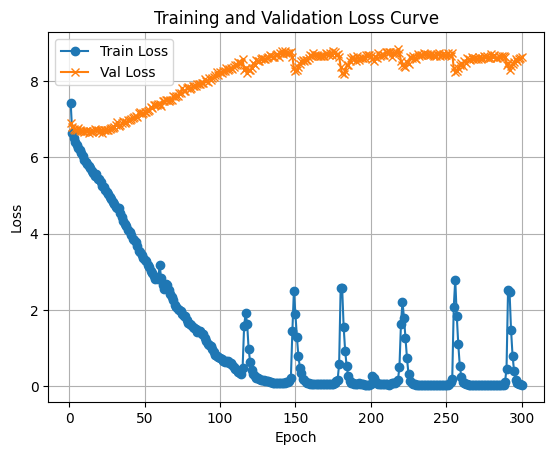

In [11]:
import matplotlib.pyplot as plt

# ✅ 绘图：训练集 & 验证集 Loss 曲线
print("==============================")
plt.plot(range(1, len(train_loss_history)+1), train_loss_history, label='Train Loss', marker='o')
plt.plot(range(1, len(val_loss_history)+1), val_loss_history, label='Val Loss', marker='x')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig("checkpoint/loss_curve_bbc_500.png")
# plt.show()
print("✅ Loss 曲线图已保存。")